<a href="https://colab.research.google.com/github/Rakesh33333/Identification-of-cryptography-algorithms/blob/main/mini_projectipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training Fold 1/3
Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 271s 102ms/step - accuracy: 0.3170 - loss: 1.8161 - val_accuracy: 0.3329 - val_loss: 1.4301 - learning_rate: 0.0010
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 253s 101ms/step - accuracy: 0.3350 - loss: 1.3978 - val_accuracy: 0.3328 - val_loss: 1.3036 - learning_rate: 0.0010
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 266s 103ms/step - accuracy: 0.3326 - loss: 1.3068 - val_accuracy: 0.3332 - val_loss: 1.2843 - learning_rate: 0.0010
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 264s 104ms/step - accuracy: 0.3338 - loss: 1.3050 - val_accuracy: 0.3336 - val_loss: 1.2863 - learning_rate: 0.0010
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 257s 101ms/step - accuracy: 0.3342 - loss: 1.2898 - val_accuracy: 0.3334 - val_loss: 1.2913 - learning_rate: 0.0010
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 261s 101ms/step - accuracy: 0.3308 - loss: 1.2879 - val_accuracy: 0.3339 - val_loss: 1.2824 - learning_rate: 0.0010
Epoch 7/30
2500/2500 ━━━━━━━━━━━━

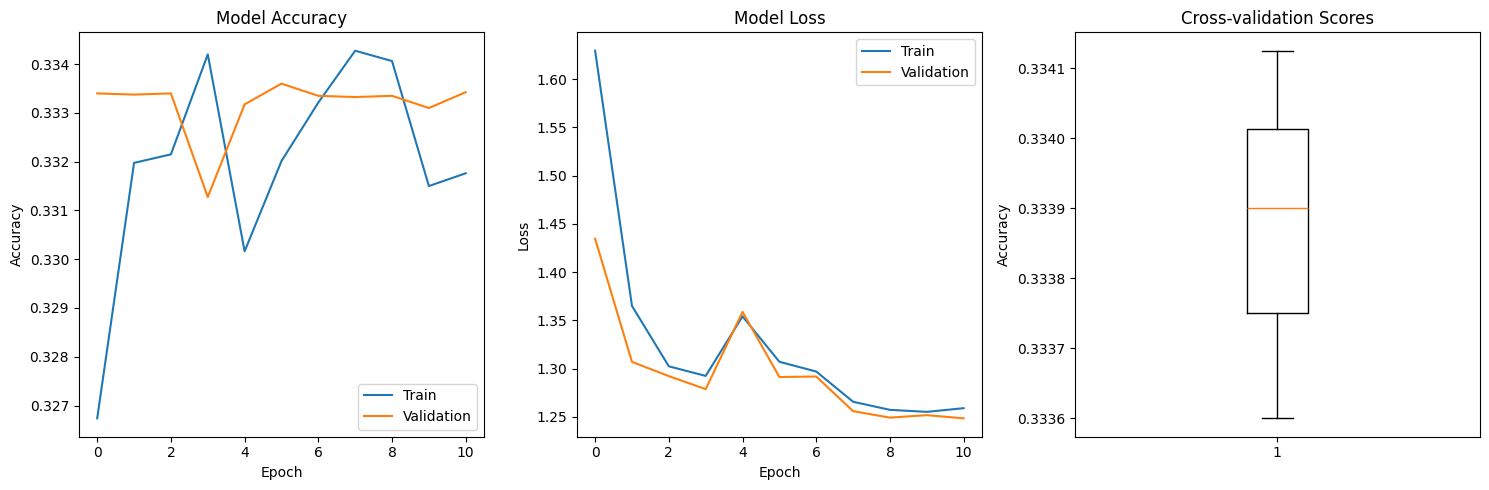

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: X has 6 features, but StandardScaler is expecting 1000 features as input.

In [ ]:
import numpy as np
import io
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Embedding, Dropout, BatchNormalization,
    Bidirectional, GlobalMaxPooling1D, concatenate, Add,
    LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.regularizers import l1_l2
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Advanced Text Preprocessing
def advanced_preprocess_text(text):
    text = str(text).lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Extract additional features
    features = {
        'length': len(text),
        'unique_chars': len(set(text)),
        'digit_ratio': sum(c.isdigit() for c in text) / len(text),
        'alpha_ratio': sum(c.isalpha() for c in text) / len(text),
        'space_ratio': sum(c.isspace() for c in text) / len(text),
        'special_ratio': sum(not c.isalnum() and not c.isspace() for c in text) / len(text)
    }
    return text, features
    # Define a function to handle potential EOF errors during CSV reading
def read_csv_with_eof_handling(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='replace') as file:
        # Replace EOF characters with a space
        # The error message mentions an 'EOF inside string',
        # so we're using a more general approach to handle potentially
        # malformed CSV data
        content = file.read().replace('\x1a', '"')  # Replace EOF with a quote
        # Wrap the content in StringIO for pandas to read
        # Use on_bad_lines='skip' to skip bad lines
        return pd.read_csv(io.StringIO(content), on_bad_lines='skip')
        # 'skip' will skip bad lines, 'warn' will warn about them

# Load Dataset, using the custom function to handle potential EOF errors
data = read_csv_with_eof_handling('/content/cryptography_dataset_processed.csv')

# ... (rest of your code remains the same)

# ... (rest of your code remains the same)

# N-gram feature extraction
def extract_ngrams(text, n=3):
    return [''.join(gram) for gram in zip(*[text[i:] for i in range(n)])]



# Process texts and extract features
processed_data = [advanced_preprocess_text(text) for text in data['Ciphertext']]
processed_texts = [item[0] for item in processed_data]
statistical_features = pd.DataFrame([item[1] for item in processed_data])

# Extract n-grams
ngrams = [extract_ngrams(text) for text in processed_texts]
ngram_counter = Counter([gram for grams in ngrams for gram in grams])
top_ngrams = dict(sorted(ngram_counter.items(), key=lambda x: x[1], reverse=True)[:1000])

# Create n-gram features
ngram_features = np.zeros((len(processed_texts), len(top_ngrams)))
for i, text_ngrams in enumerate(ngrams):
    for j, ngram in enumerate(top_ngrams.keys()):
        ngram_features[i, j] = text_ngrams.count(ngram)

# Normalize statistical and n-gram features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
statistical_features_scaled = scaler.fit_transform(statistical_features)
ngram_features_scaled = scaler.fit_transform(ngram_features)

# Tokenization
max_words = 15000
max_len = 256

# Word-level tokenization
word_tokenizer = Tokenizer(num_words=max_words)
word_tokenizer.fit_on_texts(processed_texts)
word_sequences = word_tokenizer.texts_to_sequences(processed_texts)
X_word = pad_sequences(word_sequences, maxlen=max_len)

# Character-level tokenization
char_tokenizer = Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(processed_texts)
char_sequences = char_tokenizer.texts_to_sequences(processed_texts)
X_char = pad_sequences(char_sequences, maxlen=max_len)

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['Algorithm'])

# Enhanced LSTM model with attention and residual connections
def create_advanced_model(word_vocab_size, char_vocab_size, max_len, n_classes):
    # Word-level branch
    word_input = Input(shape=(max_len,))
    word_embedding = Embedding(word_vocab_size, 256)(word_input)

    # Multi-head attention for word embeddings
    word_attention = MultiHeadAttention(num_heads=8, key_dim=32)(word_embedding, word_embedding)
    word_attention = LayerNormalization()(word_attention + word_embedding)

    # Bidirectional LSTM with residual connections
    word_lstm1 = Bidirectional(LSTM(128, return_sequences=True))(word_attention)
    word_residual1 = Add()([word_attention, word_lstm1])
    word_lstm2 = Bidirectional(LSTM(64, return_sequences=True))(word_residual1)
    word_max_pool = GlobalMaxPooling1D()(word_lstm2)

    # Character-level branch
    char_input = Input(shape=(max_len,))
    char_embedding = Embedding(char_vocab_size, 64)(char_input)

    char_attention = MultiHeadAttention(num_heads=4, key_dim=16)(char_embedding, char_embedding)
    char_attention = LayerNormalization()(char_attention + char_embedding)

    char_lstm = Bidirectional(LSTM(64, return_sequences=True))(char_attention)
    char_max_pool = GlobalMaxPooling1D()(char_lstm)

    # Statistical features input
    stat_input = Input(shape=(statistical_features.shape[1],))

    # N-gram features input
    ngram_input = Input(shape=(len(top_ngrams),))

    # Combine all features
    combined = concatenate([
        word_max_pool,
        char_max_pool,
        stat_input,
        ngram_input
    ])

    # Dense layers with residual connections and regularization
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    residual = Dense(256, activation='linear')(x)
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Add()([x, residual])
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(
        inputs=[word_input, char_input, stat_input, ngram_input],
        outputs=output
    )

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=0.001,
        weight_decay=0.001
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# K-fold cross-validation
n_folds = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_word, labels)):
    print(f"\nTraining Fold {fold + 1}/{n_folds}")

    # Split data for this fold
    X_word_train, X_word_val = X_word[train_idx], X_word[val_idx]
    X_char_train, X_char_val = X_char[train_idx], X_char[val_idx]
    X_stat_train, X_stat_val = statistical_features_scaled[train_idx], statistical_features_scaled[val_idx]
    X_ngram_train, X_ngram_val = ngram_features_scaled[train_idx], ngram_features_scaled[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Initialize model
    model = create_advanced_model(
        max_words,
        len(char_tokenizer.word_index) + 1,
        max_len,
        len(set(labels))
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.00001
        )
    ]

    # Calculate class weights
    class_weights = dict(zip(
        range(len(set(labels))),
        len(labels) / (len(set(labels)) * np.bincount(labels))
    ))

    # Train model
    history = model.fit(
        [X_word_train, X_char_train, X_stat_train, X_ngram_train],
        y_train,
        validation_data=([X_word_val, X_char_val, X_stat_val, X_ngram_val], y_val),
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weights
    )

    # Evaluate fold
    val_loss, val_acc = model.evaluate(
        [X_word_val, X_char_val, X_stat_val, X_ngram_val],
        y_val,
        verbose=0
    )
    fold_scores.append(val_acc)

    print(f"Fold {fold + 1} Validation Accuracy: {val_acc:.4f}")

print("\n=== Cross-validation Results ===")
print(f"Mean Accuracy: {np.mean(fold_scores):.4f}")
print(f"Std Accuracy: {np.std(fold_scores):.4f}")

# Function for making predictions
def predict_algorithm(ciphertext):
    # Preprocess input
    processed_text, stat_features = advanced_preprocess_text(ciphertext)

    # Word-level features
    word_seq = word_tokenizer.texts_to_sequences([processed_text])
    word_padded = pad_sequences(word_seq, maxlen=max_len)

    # Char-level features
    char_seq = char_tokenizer.texts_to_sequences([processed_text])
    char_padded = pad_sequences(char_seq, maxlen=max_len)

    # Statistical features
    stat_features_df = pd.DataFrame([stat_features])
    stat_features_scaled = scaler.transform(stat_features_df)
    stat_scaler = StandardScaler()
    stat_features_scaled = stat_scaler.fit_transform(stat_features_df)


    # N-gram features
    text_ngrams = extract_ngrams(processed_text)
    ngram_feat = np.zeros(len(top_ngrams))
    for i, ngram in enumerate(top_ngrams.keys()):
        ngram_feat[i] = text_ngrams.count(ngram)
    ngram_feat_scaled = scaler.transform(ngram_feat.reshape(1, -1))

    # Make prediction
    prediction = model.predict([
        word_padded,
        char_padded,
        stat_features_scaled,
        ngram_feat_scaled
    ])
    predicted_class = np.argmax(prediction[0])

    return label_encoder.inverse_transform([predicted_class])[0]

# Plot final results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 3, 3)
plt.boxplot(fold_scores)
plt.title('Cross-validation Scores')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Example usage
test_text = "Your ciphertext here"
prediction = predict_algorithm(test_text)
print(f"Predicted Algorithm: {prediction}")

In [ ]:
pip install pycryptodome cryptography


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.9 MB/s eta 0:00:00


In [12]:
import binascii
import base64
import re
import math
from collections import Counter

def detect_algorithm(ciphertext):
    # Check if the input is hex or Base64
    try:
        ciphertext_bytes = bytes.fromhex(ciphertext)  # Try converting from hex
        encoding = "Hexadecimal"
    except ValueError:
        try:
            ciphertext_bytes = base64.b64decode(ciphertext)  # Try Base64 decoding
            encoding = "Base64"
        except Exception:
            return "Invalid ciphertext format"

    length = len(ciphertext_bytes)

    # Entropy Calculation (Higher entropy suggests stronger encryption)
    entropy = -sum(freq / length * math.log2(freq / length) for freq in Counter(ciphertext_bytes).values())

    # Common Length Patterns
    if length % 16 == 0:
        block_size = 16
        possible_algo = "AES (128, 192, or 256-bit)"
    elif length % 8 == 0:
        block_size = 8
        if length <= 16:
            possible_algo = "DES (56-bit)"
        else:
            possible_algo = "Triple DES (3DES, 168-bit)"
    elif length > 20 and entropy > 7.5:
        block_size = "Variable"
        possible_algo = "RC4 (Stream Cipher)"
    elif re.match(r'^[0-9a-fA-F]{130,}$', ciphertext):  # ECC keys are long hex values
        block_size = "Variable"
        possible_algo = "ECC (Elliptic Curve Cryptography)"
    else:
        block_size = "Unknown"
        possible_algo = "Unknown or Non-standard Algorithm"

    # Print Analysis
    result = f"""
    🔍 Encryption Analysis:
    ----------------------------
    Encoding Format: {encoding}
    Ciphertext Length: {length} bytes
    Block Size: {block_size} bytes
    Estimated Algorithm: {possible_algo}
    Entropy Score: {entropy:.2f} (Higher = More Randomness)
    """
    return result

# User Input
ciphertext = input("Enter the ciphertext (hex/Base64): ")
result = detect_algorithm(ciphertext)
print(result)


Enter the ciphertext (hex/Base64): 91a2b3c4d5e6f7a8b9c0d1e2f3g4h5i6

    🔍 Encryption Analysis:
    ----------------------------
    Encoding Format: Base64
    Ciphertext Length: 24 bytes
    Block Size: 8 bytes
    Estimated Algorithm: Triple DES (3DES, 168-bit)
    Entropy Score: 3.86 (Higher = More Randomness)
    
